# Random Cross-Validation by_method

In [1]:
import os 

import matplotlib.pyplot as plt

import networkx as nx

import pybel
from pybel_tools.summary import plot_summary, count_top_centrality

from diffupy.process_network import process_kernel_from_file
from diffupy.utils import from_json, to_json

from diffupath.constants import DEFAULT_DIFFUPATH_DIR, ROOT_RESULTS_DIR
from diffupath.utils import reduce_dict_dimension

## 1. PathMeUniverse graph and kernel import

##### Import graph

PathMe Universe v1.0.0
Number of Nodes: 42272
Number of Edges: 105871
Number of Citations: 7695
Number of Authors: 0
Network Density: 5.92E-05
Number of Components: 435
Number of Warnings: 0


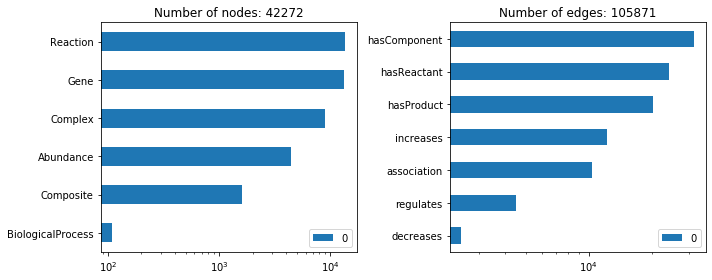

In [3]:
GRAPH_PATH = os.path.join(DEFAULT_DIFFUPATH_DIR, 'pickles', 'universe', 'pathme_universe_non_flatten_collapsed_names_no_isolates_16_03_2020.pickle')

pathme_universe_graph_no_flatten = pybel.from_pickle(GRAPH_PATH)
pathme_universe_graph_no_flatten.summarize()

nx.number_of_isolates(pathme_universe_graph_no_flatten)
pathme_universe_graph_no_flatten.remove_nodes_from({
    node
    for node in nx.isolates(pathme_universe_graph_no_flatten)
})

plot_summary(pathme_universe_graph_no_flatten, plt, figsize=(10, 4))
plt.show()

### Import KEGG

In [4]:
from pybel.struct import get_subgraph_by_annotation_value

kegg_pathme_graph_no_flatten = get_subgraph_by_annotation_value(pathme_universe_graph_no_flatten, 'database', 'kegg')
kegg_pathme_graph_no_flatten.summarize()


None vNone
Number of Nodes: 13228
Number of Edges: 36242
Number of Citations: 1
Number of Authors: 0
Network Density: 2.07E-04
Number of Components: 65
Number of Warnings: 0


In [5]:
from diffupy.kernels import regularised_laplacian_kernel

kernel_kegg = regularised_laplacian_kernel(kegg_pathme_graph_no_flatten)

/Users/Projects/MultiPath/diffuPy/src/diffupy/utils.py:30: UserWarning: Since graph is directed, it will be converted to an undirected graph.
  warnings.warn('Since graph is directed, it will be converted to an undirected graph.')


##### Import kernel

In [ ]:
KERNEL_PATH = os.path.join(DEFAULT_DIFFUPATH_DIR, 'kernels', 'kernel_regularized_pathme_universe.pickle')

kernel = process_kernel_from_file(KERNEL_PATH)

## 2. Load/import preprocessed datasets mapping 

##### Dataset 1

In [6]:
MAPPING_PATH_DATASET_1 = os.path.join(ROOT_RESULTS_DIR, 'data', 'input_mappings', 'dataset_1_mapping.json')

dataset1_mapping_by_database_and_entity = from_json(MAPPING_PATH_DATASET_1)

In [7]:
dataset1_mapping_by_database = reduce_dict_dimension(dataset1_mapping_by_database_and_entity)

dataset1_mapping_all_labels = {entity:entity_value for entity_type, entity_set in dataset1_mapping_by_database.items() for entity, entity_value in entity_set.items()}


In [8]:
dataset1_mapping_kegg = dataset1_mapping_by_database['kegg']

##### Dataset 2

In [9]:
MAPPING_PATH_DATASET2 = os.path.join(ROOT_RESULTS_DIR, 'data', 'input_mappings', 'dataset_2_mapping.json')

dataset2_mapping_by_database_and_entity = from_json(MAPPING_PATH_DATASET2)

In [10]:
dataset2_mapping_by_database = reduce_dict_dimension(dataset2_mapping_by_database_and_entity)

dataset2_mapping_all_labels = {entity:entity_value for entity_type, entity_set in dataset2_mapping_by_database.items() for entity, entity_value in entity_set.items()}

In [11]:
dataset2_mapping_kegg = dataset2_mapping_by_database['kegg']

##### Dataset 3

In [12]:
MAPPING_PATH_DATASET3 = os.path.join(ROOT_RESULTS_DIR, 'data', 'input_mappings', 'dataset_3_mapping.json')

dataset3_mapping_by_database_and_entity = from_json(MAPPING_PATH_DATASET3)

In [13]:
dataset3_mapping_by_database = reduce_dict_dimension(dataset3_mapping_by_database_and_entity)

dataset3_mapping_all_labels = {entity:entity_value for entity_type, entity_set in dataset3_mapping_by_database.items() for entity, entity_value in entity_set.items()}

In [14]:
dataset3_mapping_kegg = dataset3_mapping_by_database['kegg']

## 3. Evaluation: random cross-validation by method

In [15]:
from diffupath.views import show_box_plot, fdr_barchart_three_plot

from diffupath.cross_validation import cross_validation_by_method

from collections import defaultdict

In [16]:
metrics_by_method = defaultdict(lambda: defaultdict(lambda: list))

In [17]:
metrics_by_method['auroc']['Dataset 1'], metrics_by_method['auprc']['Dataset 1'] = cross_validation_by_method(dataset1_mapping_kegg, 
                                                                                                              kegg_pathme_graph_no_flatten, 
                                                                                                              kernel_kegg, 
                                                                                                              k = 3)

100%|██████████| 3/3 [00:41<00:00, 13.93s/it]


In [18]:
metrics_by_method['auroc']['Dataset 2'], metrics_by_method['auprc']['Dataset 2'] = cross_validation_by_method(dataset2_mapping_kegg, 
                                                                                                               kegg_pathme_graph_no_flatten, 
                                                                                                               kernel_kegg, 
                                                                                                               k = 3)

100%|██████████| 3/3 [00:40<00:00, 13.42s/it]


In [19]:
metrics_by_method['auroc']['Dataset 3'], metrics_by_method['auprc']['Dataset 3'] =  cross_validation_by_method(dataset3_mapping_kegg, 
                                                                                                               kegg_pathme_graph_no_flatten, 
                                                                                                               kernel_kegg, 
                                                                                                               k = 3)

100%|██████████| 3/3 [00:41<00:00, 13.77s/it]


##### Result metrics views

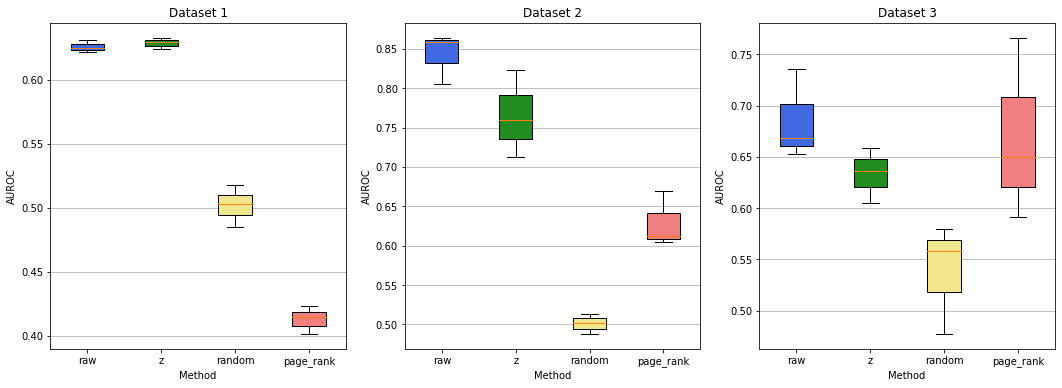

In [20]:
show_box_plot(metrics_by_method['auroc'], 'Method', 'AUROC')



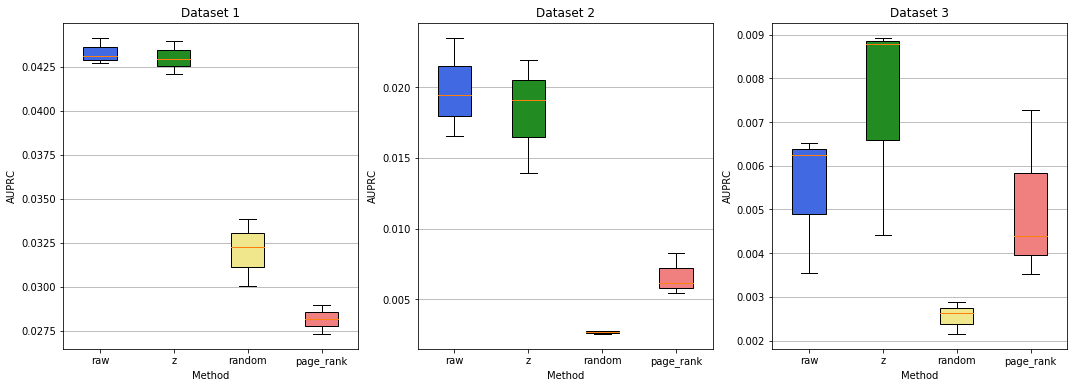

In [21]:
show_box_plot(metrics_by_method['auprc'], 'Method', 'AUPRC')


##### Statistical test FDR p-values

In [22]:
from diffupath.cross_validation import get_p_values

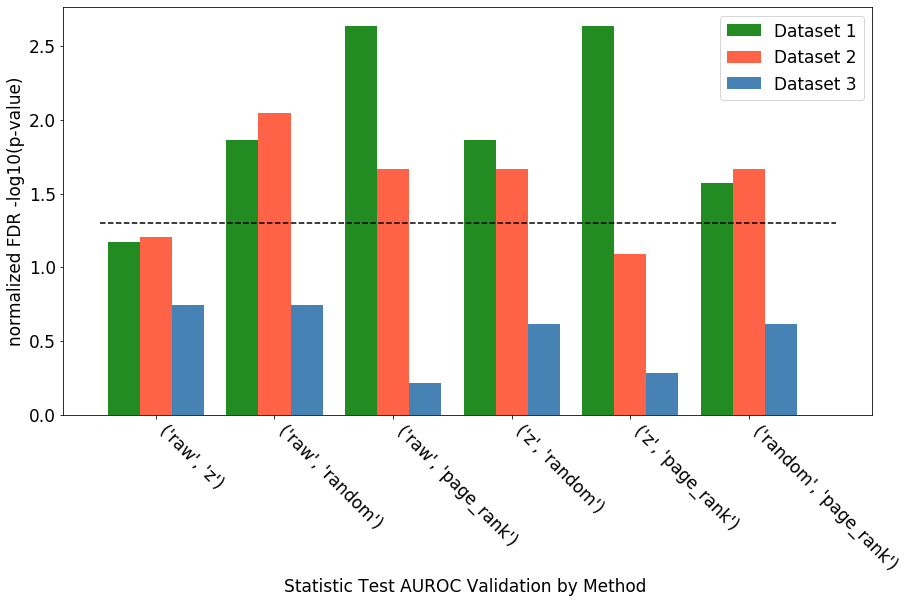

In [23]:
fdr_barchart_three_plot(metrics_by_method['auroc'], get_p_values, 'Statistic Test AUROC Validation by Method ')


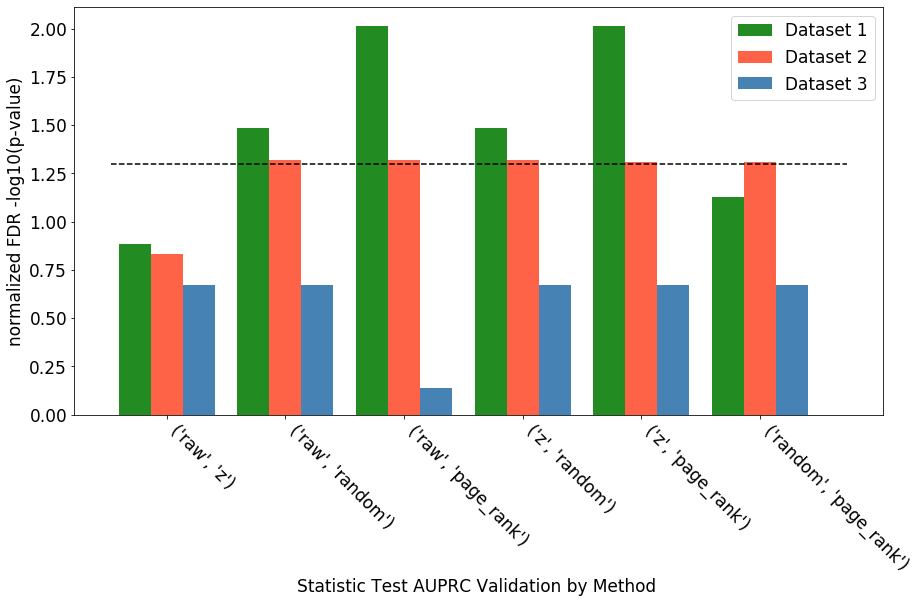

In [24]:
fdr_barchart_three_plot(metrics_by_method['auprc'], get_p_values, "Statistic Test AUPRC Validation by Method ")


##### Save evaluation by method to exportable .json file

In [25]:
OUTPUT_PATH = os.path.join(ROOT_RESULTS_DIR, 'outputs', 'metrics_by_method_validation.json')
to_json(metrics_by_method, OUTPUT_PATH)